In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load data
data = pd.read_csv('ht_public.csv')

#we are going to use the train data only
data = data[data["group"]=="train"]


In [2]:
data.describe()

,member_id,order_year,f1,f3,f5,f6,f7,is_purchase
count,12000.00000,12000.000000,12000.000000,9797.000000,12000.000000,12000.000000,12000.000000,11995.000000
mean,5999.50000,2022.750083,2.005083,0.453404,10.039588,10.092093,2.495667,0.100542
std,3464.24595,0.721805,0.817484,0.497849,5.240383,5.247832,1.116058,0.300734
min,0.00000,2022.000000,1.000000,0.000000,0.010000,-0.010000,1.000000,0.000000
25%,2999.75000,2022.000000,1.000000,0.000000,6.300000,6.400000,1.000000,0.000000
50%,5999.50000,2023.000000,2.000000,0.000000,10.000000,10.000000,2.000000,0.000000
75%,8999.25000,2023.000000,3.000000,1.000000,13.600000,13.700000,3.000000,0.000000
max,11999.00000,2024.000000,3.000000,1.000000,29.300000,32.800000,4.000000,1.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    12000 non-null  int64  
 1   group        12000 non-null  object 
 2   order_year   12000 non-null  int64  
 3   f1           12000 non-null  int64  
 4   f2           12000 non-null  object 
 5   f3           9797 non-null   float64
 6   f4           118 non-null    object 
 7   f5           12000 non-null  float64
 8   f6           12000 non-null  float64
 9   f7           12000 non-null  int64  
 10  is_purchase  11995 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 1.1+ MB


In [4]:
data["member_id"].duplicated().sum()

0

In [5]:
data = data.query("is_purchase == is_purchase", engine="python")

In [6]:
data = data.drop(columns=["f4"])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11995 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    11995 non-null  int64  
 1   group        11995 non-null  object 
 2   order_year   11995 non-null  int64  
 3   f1           11995 non-null  int64  
 4   f2           11995 non-null  object 
 5   f3           9793 non-null   float64
 6   f5           11995 non-null  float64
 7   f6           11995 non-null  float64
 8   f7           11995 non-null  int64  
 9   is_purchase  11995 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 1.0+ MB


In [8]:
data["is_purchase"].value_counts()

0.0    10789
1.0     1206
Name: is_purchase, dtype: int64

# EDA
Firstly, let's get some basic understanding of the data

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
EDA = data.drop(columns = ["member_id"])

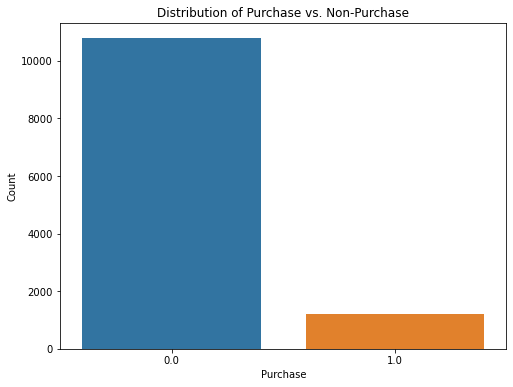

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_purchase', data=EDA)
plt.title('Distribution of Purchase vs. Non-Purchase')
plt.xlabel('Purchase')
plt.ylabel('Count')
plt.show()


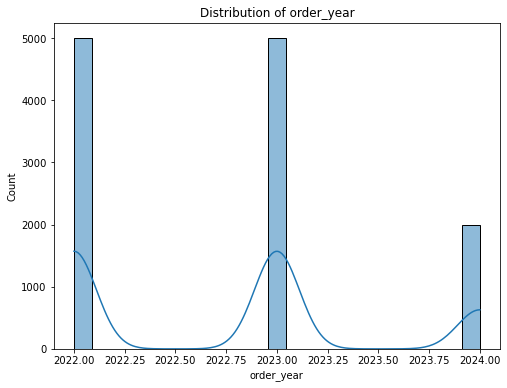

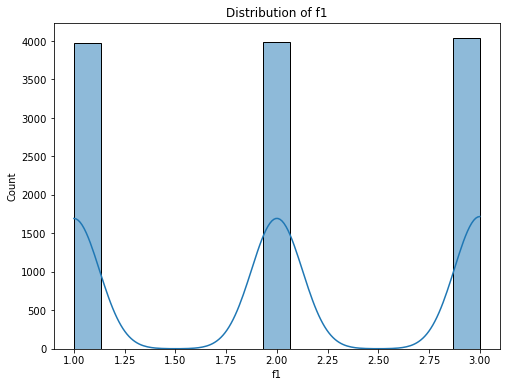

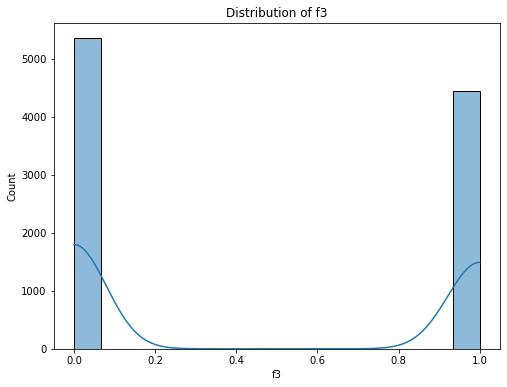

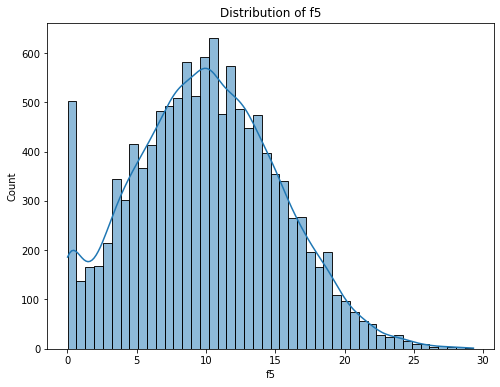

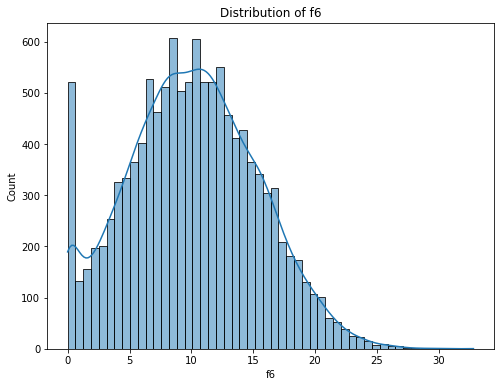

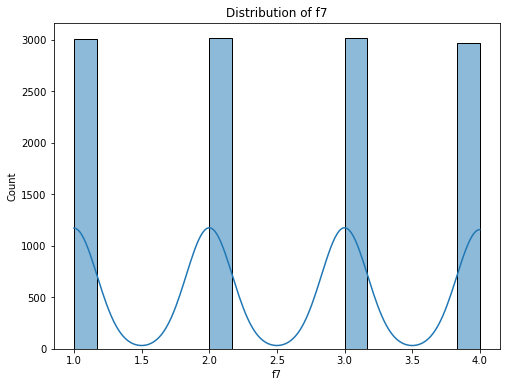

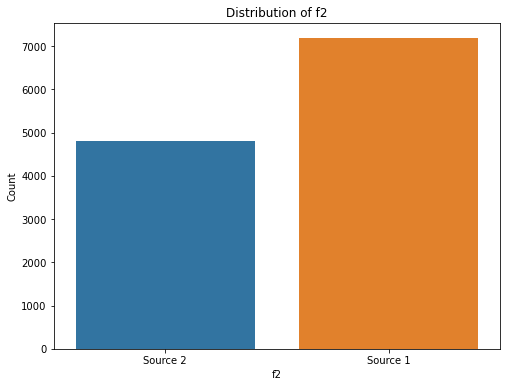

In [11]:
numeric_features = ['order_year', 'f1', 'f3', 'f5', 'f6', 'f7']

for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(EDA[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='f2', data=EDA)
plt.title('Distribution of f2')
plt.xlabel('f2')
plt.ylabel('Count')
plt.show()


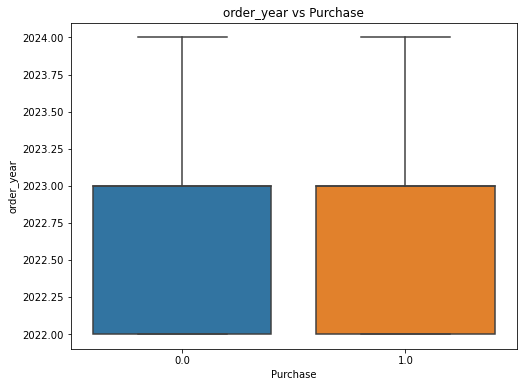

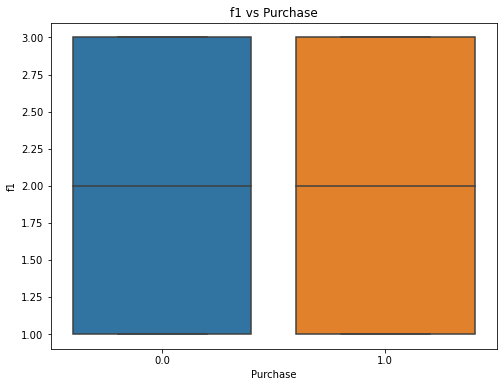

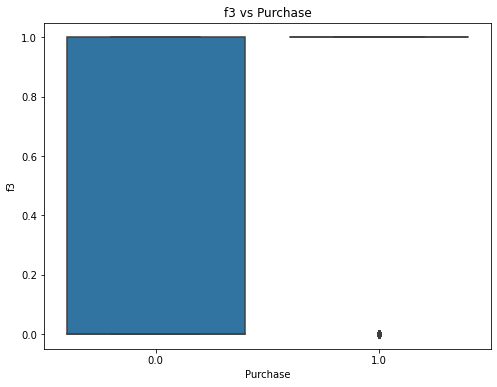

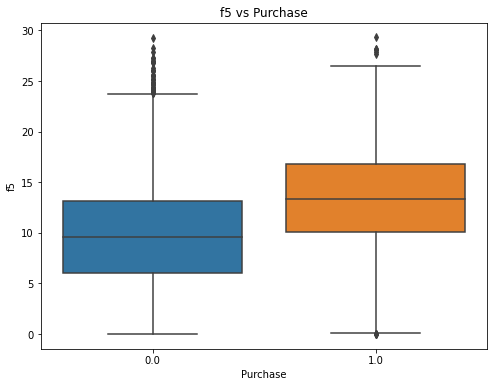

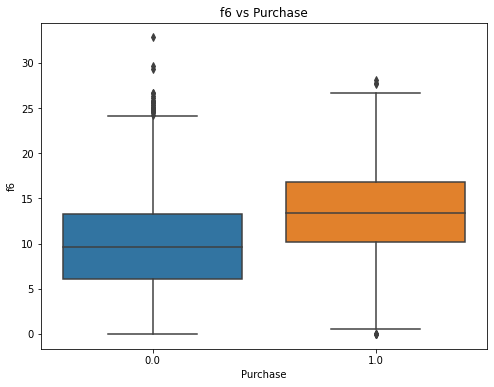

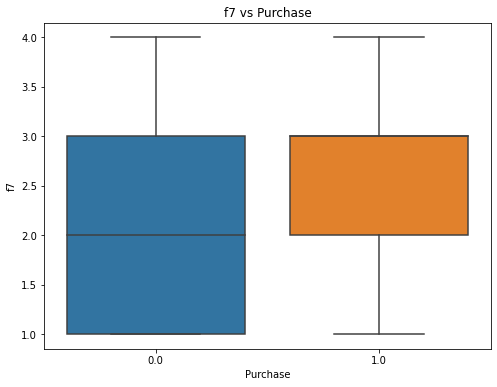

In [12]:
# Visualizing the relationship between numerical features and target variable

for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='is_purchase', y=feature, data=data)
    plt.title(f'{feature} vs Purchase')
    plt.xlabel('Purchase')
    plt.ylabel(feature)
    plt.show()


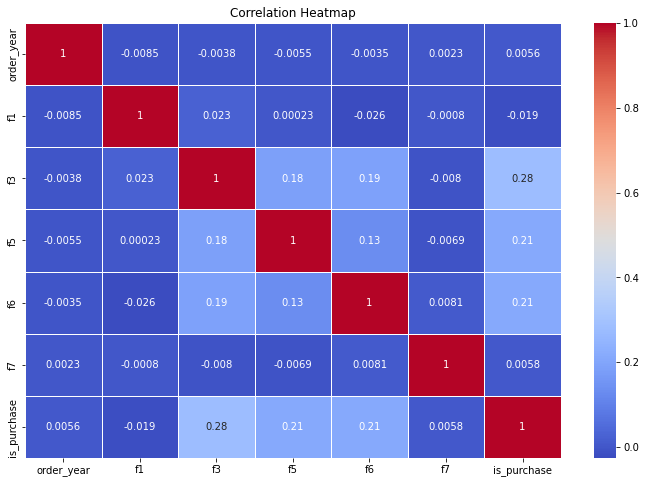

In [13]:
plt.figure(figsize=(12, 8))
correlation_matrix = EDA.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_features = ['order_year', 'f1', 'f3', 'f5', 'f6', 'f7']

def cal_vif(data, features):
    VIF = data[features]
    VIF = VIF.dropna()
    vif_data = pd.DataFrame()
    vif_data['feature'] = VIF.columns
    vif_data['VIF'] = [variance_inflation_factor(VIF.values, i) for i in range(VIF.shape[1])]
    return vif_data
cal_vif(data, numeric_features)

,feature,VIF
0,order_year,18.960890
1,f1,7.046871
2,f3,1.954433
3,f5,4.845849
4,f6,4.905626
5,f7,6.012593


Feature Engineering

Here, as this is a simple dataset and the order year has a higher VIF. I will transforme order_year to relative_year, as in this case, I assumes that the absolute year is less important than the relative passage of time. E.g. if a reward program is just announced it is not likely to be knowned by many people at the begining compared to two years later. 

In [15]:
earliest_year = data['order_year'].min()
data['relative_year'] = data['order_year'] - earliest_year
numeric_features = ['relative_year', 'f1', 'f3', 'f5', 'f6', 'f7']
cal_vif(data, numeric_features)

,feature,VIF
0,relative_year,1.882941
1,f1,4.812337
2,f3,1.949603
3,f5,4.183018
4,f6,4.198031
5,f7,4.500032


In [16]:
# Use Label Encoding as it is binary nominal class, not nessesary to increase the dimension
data['f2'] = data['f2'].map({'Source 1': 0, 'Source 2': 1}) 

In [17]:
data["f3"].isna().sum()/len(data), data[data["f3"].isna()]["is_purchase"].value_counts()

(0.18357649020425176,
 0.0    1793
 1.0     409
 Name: is_purchase, dtype: int64)

In [18]:
data["f3"].value_counts(), data["is_purchase"].value_counts()

(0.0    5352
 1.0    4441
 Name: f3, dtype: int64,
 0.0    10789
 1.0     1206
 Name: is_purchase, dtype: int64)

In [19]:
df_target_0 = data[data['is_purchase'] == 0]
df_target_1 = data[data['is_purchase'] == 1]

print(df_target_1["f3"].isna().sum(), df_target_0["f3"].isna().sum())
print(df_target_1["f3"].isna().sum() / len(df_target_0), df_target_0["f3"].isna().sum() / len(df_target_0))
print(len(df_target_1)/len(df_target_0))

409 1793
0.0379089813699138 0.1661877838539253
0.11178051719343776


In [20]:
# Calculate the mode for the binary feature in each subset
mode_target_0 = df_target_0['f3'].mode()[0]
mode_target_1 = df_target_1['f3'].mode()[0]
df_target_0['f3'].fillna(mode_target_0, inplace=True)
df_target_1['f3'].fillna(mode_target_1, inplace=True)
data_imputed = pd.concat([df_target_0, df_target_1]).sort_index()


C:\Users\Dennis\AppData\Local\Temp\ipykernel_24648\348142133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target_0['f3'].fillna(mode_target_0, inplace=True)
C:\Users\Dennis\AppData\Local\Temp\ipykernel_24648\348142133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target_1['f3'].fillna(mode_target_1, inplace=True)


In [22]:
feature_col = ["f1","f2","f3","f5","f6","f7","relative_year"]

# Train the data

In [25]:
from sklearn.model_selection import train_test_split
X = data_imputed[feature_col]
y = data_imputed['is_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=y)


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score, f1_score, average_precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(df_target_0)/len(df_target_1))
}

def evaluate_models(X, y, models):
    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        pipeline = ImbPipeline(steps=[('smote', SMOTE(random_state=42)),
                                      ('model', model)])
        scoring = ['roc_auc', 'precision', 'recall', 'f1', 'average_precision']
        scores = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc')
        precision_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='precision')
        recall_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='recall')
        f1_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='f1')
        average_precision_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='average_precision')

        results[name] = {
            'roc_auc': scores.min(),
            'precision': precision_scores.min(),
            'recall': recall_scores.min(),
            'f1': f1_scores.min(),
            'average_precision': average_precision_scores.min()
        }
        print(f"{name}: Mean ROC AUC = {scores.mean():.4f}, Precision = {precision_scores.mean():.4f}, Recall = {recall_scores.mean():.4f}, F1 = {f1_scores.mean():.4f}, AP = {average_precision_scores.mean():.4f}")
    return results

results = evaluate_models(X, y, models)

best_model_name = max(results, key=results.get("f1"))
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")

Logistic Regression: Mean ROC AUC = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 = 1.0000, AP = 1.0000
Random Forest: Mean ROC AUC = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 = 1.0000, AP = 1.0000
Gradient Boosting: Mean ROC AUC = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 = 1.0000, AP = 1.0000
XGBoost: Mean ROC AUC = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 = 1.0000, AP = 1.0000
Best model: XGBoost


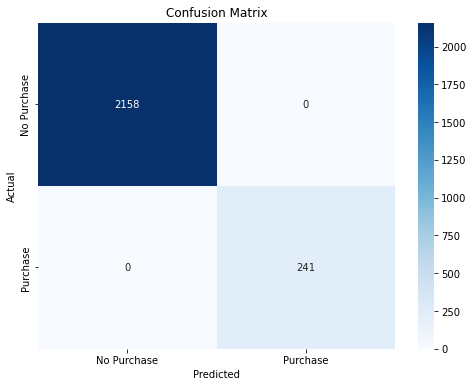

ROC AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2158
         1.0       1.00      1.00      1.00       241

    accuracy                           1.00      2399
   macro avg       1.00      1.00      1.00      2399
weighted avg       1.00      1.00      1.00      2399



In [45]:
def plot_evaluation_metrics(y_test, y_pred, y_pred_proba):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Purchase', 'Purchase'], yticklabels=['No Purchase', 'Purchase'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print Evaluation Metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred_proba)
    
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Precision: {average_precision:.4f}")
    
    # Optional: Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

best_model.fit(X_train, y_train)
# Predict on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_pred_proba)

In [ ]:
y_pred